---
title: "Weights and bias to keep track of training run"
author: "Alex Kelly"
date: "2024-02-22"
format:
  html:
    code-fold: False
    toc : true
    numbered-sections : true
jupyter : python3
draft : True
---


# Overview

The blog will run you through a simple training loop and help understand how to intergrate weights and bias into your training loops using the mini ai from Fast AI.

# What is weights and bias

Weights and Bias is a machine learning platform similar to Tensorflow Tensor boards where it helps keep track of machine learning runs and helps visualise and share the results.  Its hosted by weights and bias and is indepent to the notebook.  Due to it being indendant it can be intergrated into TensorFlow, PyTorch, Keras, and Scikit-learn.  It also supports tracking and versioning of datasets, models, and other files (artifacts), facilitating better data management and model lifecycle management.



# Code from previous blog posts

I will not go over the hugging face dataloaders/dataloaders as ive already shown in another blog post.  The aim is to show the weights and bias loggings

## all the setup code from part 1

Creating the dataset

code calapsed as we have already seen this in the previous blog post


In [ ]:
#| echo: True
#| output: False 
#| code-fold: true

# install and import the necessary libraries
!pip install datasets[vision]
!pip install torcheval


from datasets import load_dataset, Image

import os
import sys
from datasets import Dataset, Image
import torch
# creates a DataLoader object that can be used to iterate through the dataset
from torch.utils.data import DataLoader
# Creates a transform that converts the image to a tensor
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms.functional import to_tensor, normalize


# checks if the environment is local or remote
def check_if_local():
    # Checking for common remote environment indicators
    remote_indicators = ['COLAB_GPU', 'JUPYTERHUB_SERVICE_PREFIX']

    # If any of the indicators are present, it's likely not a local environment
    if any(indicator in os.environ for indicator in remote_indicators):
        return False
    else:
        # Assuming local environment if none of the remote indicators are found
        return True



# checks if the environment is local or remote and sets the path accordingly
if check_if_local() == False:
    print('Running in a remote environment, mounting Google Drive...')
    from google.colab import userdata
    api_key = userdata.get('wandb_key')
    from google.colab import drive
    drive.mount('/content/drive')
    data_science_folder = '/content/drive/MyDrive/Learning/data_science/'
    sys.path.append(data_science_folder)
    dataset_path = data_science_folder  + 'datasets_folder/gaze-points/work-laptop'
else :
    print('Running in a local environment...')
    # import datasets before sys.path.append to avoid conflict with local datasets
    data_science_folder = 'G:\My Drive\Learning\data_science'
    sys.path.append(data_science_folder)
    dataset_path = data_science_folder + "\\datasets_folder\gaze-points\work-laptop"

# extracts screen coordinates from the filenames and stores in a list of tensors
label_tensors = [torch.tensor([int(f.split('_')[-2]), int(f.split('_')[-1].split('.')[0])]) for f in os.listdir(dataset_path) if os.path.isfile(os.path.join(dataset_path, f))]
# Divide the first column by 2560 and the second column by 1440
label_tensors = [tensor.float() / torch.tensor([2560.0, 1440.0]) for tensor in label_tensors]

# get the last 20 elements for testings purposes
# label_tensors = label_tensors[:200]
# gets a list of all images in a directory and stores in a list of strings
image_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if os.path.isfile(os.path.join(dataset_path, f))]
# image_files = image_files[:200]
# create the dataset from the image files and labels
dataset = Dataset.from_dict({"image": image_files}).cast_column("image", Image())
# create a new dictionary with the images and labels
# i'm not happy with having to add the labels to the dataset after as it takes alot longer
# but i'm not sure how to do it in the the from_dict method above.
updated_dataset_dict = {"image": dataset["image"], "label": label_tensors}
updated_dataset = Dataset.from_dict(updated_dataset_dict)
to_tensor = transforms.ToTensor()
def transform_images_with_stack(batch):
    if "image" in batch:
        # Convert all images in the batch to tensors and collect them in a list
        images_tensor = torch.stack([to_tensor(image) for image in batch['image']])
        images_tensor = normalize(images_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # usual means nad st deviations recomended for images
        batch['image'] = images_tensor  # Replace the list of images with a stacked tensor
    if "label" in batch:
        # Convert all labels in the batch to tensors and collect them in a list
        #labels_tensor = torch.stack([torch.tensor(label) for label in batch['label']])
        labels_tensor = torch.stack([torch.tensor(label, dtype=torch.float32) for label in batch['label']])
        batch['label'] = labels_tensor  # Replace the list of labels with a stacked tensor
    return batch
# Executes the transform on the dataset, the returning dataset[image] will be a tensor
updated_dataset_with_transform = updated_dataset.with_transform(transform_images_with_stack)
# splits the dataset into a training and test set
# the test set is 20% of the dataset
# the training set is 80% of the dataset
updated_dataset_split = updated_dataset_with_transform.train_test_split(test_size=0.2)
updated_dataset_split["train"][0]["label"].type()
updated_dataset_split["train"][0]["image"].type()
updated_dataset_split["train"][0]["image"]
updated_dataset_split

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.7 MB/s eta 0:00:00


## data loaders (following Fast ai method)

dataset to dataloaders

code calapsed as we have already seen this in the previous blog post

In [ ]:
#| echo: True
#| output: False 
#| code-fold: true

# sets the batch size for the data loader
batch_size = 100
from operator import itemgetter
from torch.utils.data.dataloader import default_collate

class DataLoaders:
    def __init__(self, *dls): self.train,self.valid = dls[:2]

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        f = collate_dict(dd['train'])
        return cls(*get_dls(*dd.values(), bs=batch_size, collate_fn=f, **kwargs))
updated_dataset_split
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

def collate_dict(ds):
    get = itemgetter(*ds.features)
    def _f(b): return get(default_collate(b))
    return _f
dls = DataLoaders.from_dd(updated_dataset_split, batch_size=batch_size, num_workers=0)

dt = dls.train

xb,yb = next(iter(dt))
xb.shape
yb.shape

## Load the optimizer and learner

code calapsed as we have already seen this in the previous blog post

In [69]:
#| echo: True
#| output: False 
#| code-fold: true

from torcheval.metrics import MulticlassAccuracy
import fastcore.all as fc
from functools import partial

from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.datasets import *

## The learner

code calapsed as we have already seen this in the previous blog post

In [32]:
#| echo: True
#| output: False 
#| code-fold: true


# maybe i need to chang the loss.  do i need to consider the batch???
class TrainLearner(Learner):
    def predict(self): self.preds = self.model(self.batch[0])
    def get_loss(self): self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

# Weights and bias setup and configuration

This is where we get to the juce of the blog post.  Weights and bias, the lines below run through the install and import.

In [33]:
#| echo: True
#| output: True
!pip install wandb
import wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.7 MB/s eta 0:00:00


The activationsStats class callback collects stats on the weights and bias's of each of the models layers.  It's from the Fast.AI mini AI library with some extra details.

The initialization_neural_networks post here () shows the details of this.  In sumarry :

- Color_dim shows a histogram shows the frequency of activations
- Dead_chart shows the inactive activations
- Plot_stats shows the mean and standard deviations of each of the layers

A few changes has been made. I've added return_fig=False to each of the charts so the function returns a matplotlib fig to pass to the weights and bias's callback below.



In [76]:
#| echo: True
#| output: True

import matplotlib.pyplot as plt

# add 2 fig caps
# improved function to include labelling for the stats
class ActivationStats(HooksCallback):
    def __init__(self, mod_filter=fc.noop):
        super().__init__(append_stats, mod_filter)

    def color_dim(self, figsize=(11,5), return_fig=False):
      fig, axes = get_grid(len(self), figsize=figsize)
      for ax, h in zip(axes.flat, self):
          im = ax.imshow(get_hist(h), origin='lower')  # Using imshow directly

          # Add labels, title, and colorbar for clarity
          ax.set_xlabel("Batch Number")
          ax.set_ylabel("Activation Value")
          ax.set_title("Layer " + "str(self.index(h))" + " Activations")
          cbar = plt.colorbar(im, ax=ax)
          cbar.set_label("Frequency")
      if return_fig == True:
        return  fig
      else :
        plt.tight_layout()  # Prevent overlap


    def dead_chart(self, figsize=(11,5), return_fig=False):
        fig, axes = get_grid(len(self), figsize=figsize)
        for ax, h in zip(axes.flatten(), self):
            ax.plot(get_min(h), linewidth=3)
            ax.set_ylim(0,1)
            ax.set_xlabel("Batch Number")
            ax.set_ylabel("Activation Value")
            ax.set_title("Layer " + "str(self.index(h))" + " Dead Activations")
        if return_fig == True:
          return  fig
        else :
          plt.tight_layout()  # Prevent overlapww

    def plot_stats(self, figsize=(10,4), return_fig=False):
        fig, axs = plt.subplots(1,2, figsize=figsize)
        for h in self:
            for i in 0,1:
                axs[i].plot(h.stats[i])
        axs[0].set_title('Means')
        axs[1].set_title('Stdevs')
        axs[0].set_xlabel("Batch Number")
        axs[1].set_xlabel("Batch Number")
        axs[0].set_ylabel("Mean Activation Value")
        axs[1].set_ylabel("Standard Deviation of Activation Value")
        plt.legend(fc.L.range(self))
        if return_fig == True:
          return  fig
        else :
          plt.tight_layout()  # Prevent overlap

The weights and bias's callback WandBC taken from jonathan witakers mini ai and slightly modified to do a few extra things i required.  I've added a few things i thought would be useful@

- a option to upload a notebook for each training run, providing the data and hte same hardware you can reproduce the same results.  
- add each of the activation charts to the output.

In [77]:
#| echo: True
#| output: True

class WandBCB(MetricsCB):
    order=100
    def __init__(self, config, *ms, project='ddpm_cifar10',notebook_path=None, **metrics):
        fc.store_attr()
        super().__init__(*ms, **metrics)

    def before_fit(self, learn):
      print(notebook_path)
      wandb.init(project=self.project, config=self.config)
      if notebook_path != None:
          # Log the notebook
          artifact = wandb.Artifact('notebook', type='notebook')
          artifact.add_file(notebook_path)
          wandb.log_artifact(artifact)


    def after_fit(self, learn): wandb.finish()

    def _log(self, d):
        if learn.training:
            wandb.log({'train_'+m:float(d[m]) for m in self.all_metrics})
        else:
            wandb.log({'val_'+m:float(d[m]) for m in self.all_metrics})
            # wandb.log({'samples':self.sample_figure(learn)})
            wandb.log({'dead_chart':astats.dead_chart(return_fig=True)})
            wandb.log({'color_dim':astats.color_dim(return_fig=True)})
            wandb.log({'plot_stats':astats.plot_stats(return_fig=True)})
            print(d)

    def sample_figure(self, learn):
        with torch.no_grad():
            samples = sample(learn.model, (16, 3, 32, 32))
        s = (samples[-1] + 0.5).clamp(0,1)
        plt.clf()
        fig, axs = get_grid(16)
        for im,ax in zip(s[:16], axs.flat): show_image(im, ax=ax)
        return fig

    def after_batch(self, learn):
        super().after_batch(learn)
        wandb.log({'loss':learn.loss})

# Train the model

Simple CNN model, the purpose here isn't to build the best model but to keep things simple to concentrate on the weights and bias's setup and logging.

In [78]:
#| echo: True
#| output: True

class CoordinateCNN(nn.Module):
    def __init__(self):
        super(CoordinateCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # BatchNorm for the first conv layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # BatchNorm for the second conv layer
        self.fc1 = nn.Linear(64 * 120 * 160, 128)
        self.fc2 = nn.Linear(128, 2)  # Output layer for x, y coordinates

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)  # Apply BatchNorm after the first conv layer
        x = torch.relu(x)
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = self.conv2(x)
        x = self.bn2(x)  # Apply BatchNorm after the second conv layer
        x = torch.relu(x)
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 64 * 120 * 160)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

iw = partial(init_weights, leaky=0.1)
model = CoordinateCNN()
model.to()

CoordinateCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1228800, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [79]:
#| echo: True
#| output: True

LR=6e-3
epoch = 1
optimizer = optim.Adam

loss_func = F.mse_loss
metrics = MetricsCB()
astats = ActivationStats(fc.risinstance(nn.Conv2d))

#cbs = [DeviceCB(),metrics, ProgressCB(plot=True), astats]

Setting up the callback for the weights and bias's with the correct parameters.  It accepts the following :

- Project : The project name that will be displayed in weights and bias
- Config : Takes in the learning rate, number of epochs and the comments, the
- Notebook_path : Path to the notebook, if this is left empty or isnt passed, it will not save the notebook to the training run to weights and bias.


In [80]:
#| echo: True
#| output: True

# Replace with the path to your notebook
notebook_path = '/content/drive/My Drive/Colab Notebooks/WeightsAndBias.ipynb'
wandbcb =  WandBCB(project="weights_and_bias_test", config={'lr':LR, 'epochs':epoch, 'comments':'testing weights and bias'}, notebook_path=notebook_path)


In [81]:
#| echo: True
#| output: True
cbs = [DeviceCB(),wandbcb, ProgressCB(plot=True), astats]


/content/drive/My Drive/Colab Notebooks/WeightsAndBias.ipynb


loss,▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▁
val_loss,▁
loss,28068.73438
train_loss,3092647.278
val_loss,28530.218


{'loss': '4703.878', 'epoch': 0, 'train': 'eval'}


loss,▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▁
val_loss,▁
loss,4706.77002
train_loss,2538186.249
val_loss,4703.878


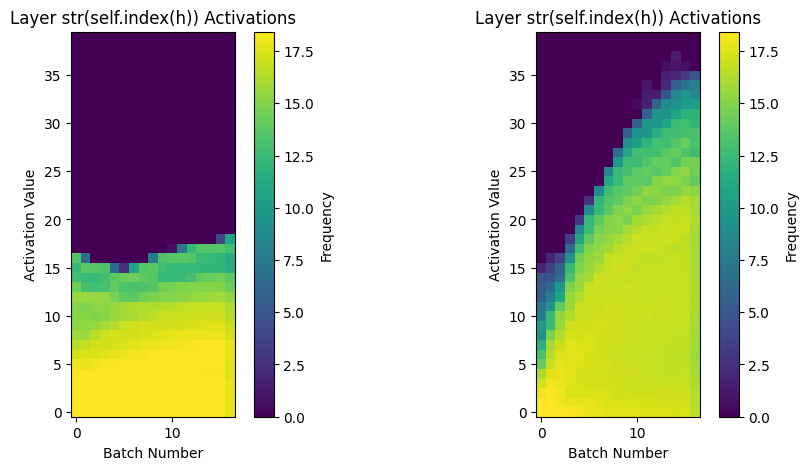

In [83]:
#| echo: True
#| output: True

# creates the learner object and passes the model, dataloaders (the data), loss function, learning rate,
# callbacks and optimizer function
learn = TrainLearner(model, dls, loss_func, LR, cbs=cbs, opt_func=optimizer)
learn.fit(epoch)

The picture below shows  a screen shot of the weights and bias's dashboard showing the training run.  The dashboard shows the loss, the accuracy and activations charts among other things like gpu usage and system metrics. 

![](weights_bias.png)

# Retreive Results

To download a notebook previously uploaded, you can use the code below to download it the root folder.

In [133]:
import wandb
run = wandb.init()
artifact = run.use_artifact('kelster101757/weights_and_bias_test/notebook:v2', type='notebook')
artifact_dir = artifact.download()

wandb:   1 of 1 files downloaded.  
